- dataset을 분석하기 위한 코드 부분
    - LLM caption들을 여기에 저장할 것이다.

In [14]:
import os
import pandas as pd
import numpy as np

In [15]:
# dataset main path
data_root = "/workspace/data/3ddst/train"
dataset_types = ["annotation", "cannyedge_render", "depth", "image_render", "normal_render"]

In [94]:
meta_class_list = [
    d for d in os.listdir(data_root)
    if os.path.isdir(os.path.join(data_root, d)) 
]
print(f"Found {len(meta_class_list)} meta classes in the dataset.")

Found 498 meta classes in the dataset.


In [45]:
class_dict = {
}  # {key: meta_class, vaue: class_list}
class_list = []  # concatenated list of all classes

for each_meta_class in meta_class_list:
    class_path = os.path.join(data_root, each_meta_class)
    valid_sub_classes = []
    for each_class in os.listdir(class_path):
        if not os.path.isdir(class_path):
            continue
        # currently to save pose as .npy in annotation folder
        annot_path = os.path.join(class_path, each_class, "annotation")
        if os.path.exists(annot_path):
            annotation_files = [f for f in os.listdir(
                annot_path) if f.endswith(".npy")]
            if len(annotation_files) > 1:  # Requirement 4: Exclude if 1 or fewer files
                valid_sub_classes.append(each_class)
        
        class_dict[each_meta_class] = valid_sub_classes
        class_list.extend(valid_sub_classes)
    
    if len(valid_sub_classes) == 0:
        print(f"Warning: No valid classes found in meta class '{each_meta_class}'.")
        del class_dict[each_meta_class]
        meta_class_list.remove(each_meta_class)

In [ ]:
# statistics per meta class
class_numbers = {
    k: len(v) for k, v in class_dict.items()    
}
class_num_list = np.array([v for v in class_numbers.values()])
print(
    f"Total number of classes: {len(class_list)} "
    f"Average number of classes per meta class: {np.mean(class_num_list):.2f} "
    f"standard deviation: {np.std(class_num_list):.2f} "
    f"median: {np.median(class_num_list):.2f} "
    f"min: {np.min(class_num_list):.2f} "
    f"max: {np.max(class_num_list):.2f} "
    ,sep="\n"
)
# 특수한 경우 발견, n02971356, valid sub class가 하나도 없는 경우

Total number of classes: 28511 Average number of classes per meta class: 9.24 standard deviation: 3.59 median: 9.00 min: 1.00 max: 21.00 


In [98]:
# dataframe construction
data = []
for each_meta_class, each_class_list in class_dict.items():
    for each_class in each_class_list:
        sub_class_path = os.path.join(data_root, each_meta_class, each_class)
        for dataset_type in dataset_types:
            dataset_path = os.path.join(sub_class_path, dataset_type)
            if os.path.exists(dataset_path):
                base_names = sorted([f for f in os.listdir(dataset_path)])
            else:
                base_names = []
            data.append({"meta_class": each_meta_class, "class": each_class, "dataset_type": dataset_type, "base_name": base_names})

df = pd.DataFrame(data)
df = df.explode("base_name")  # explode the list of filenames into separate rows
# df.set_index(["class", "dataset_type"], inplace=True)
df.to_csv(os.path.join("./data", "3ddst.csv"), index=False)

In [1]:
df

NameError: name 'df' is not defined

In [90]:
len(df) / (6 * 8 * 16 * 60)

5.025

- 이제 dataloader 부분을 개조하기 위함

In [4]:
df_path = "/workspace/code/3DAnything/debug/data/3ddst.csv"
df = pd.read_csv(df_path)

In [20]:
df_caption_path = "/workspace/code/3DAnything/debug/data/captions.csv"
df_caption = pd.read_csv(df_caption_path)

In [30]:
df_caption[df_caption["class"] == "78c2ceb1e51149698c6a8e6242d5dbb2"]

,meta_class,class,dataset_type,base_name,caption
1118,n02100735,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,000.png,A figurine of a puppy standing with its head t...
1119,n02100735,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,001.png,The image shows a sculpture of a reclining dog...
1120,n02100735,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,002.png,"The image shows a beige, possibly cream-colore..."
1121,n02100735,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,003.png,The image shows the back view of a light-color...
1122,n02100735,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,004.png,The image shows a sculpture of a bull with exa...
...,...,...,...,...,...
44738,n02100236,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,003.png,"The image is of a sculpture of a dog, likely a..."
44739,n02100236,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,004.png,The image shows the back view of a puppy with ...
44740,n02100236,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,005.png,The image shows a digital 3D model of a St. Be...
44741,n02100236,78c2ceb1e51149698c6a8e6242d5dbb2,image_render,006.png,The image shows a light-colored statue of a La...


In [ ]:
df[(df["class"] == "dcb921b4517a45db8853bfdd4d0cafdc") & (df["dataset_type"] == "image_render")]["base_name"].values

array(['000.png', '001.png', '002.png', '003.png', '004.png', '005.png',
       '006.png', '007.png', '008.png'], dtype=object)

In [28]:
a, b= np.random.choice(df[(df["class"] == "dcb921b4517a45db8853bfdd4d0cafdc") & (df["dataset_type"] == "image_render")]["base_name"].values, 2)
a

'005.png'

In [1]:
import OpenEXR
import Imath
import numpy as np
import matplotlib.pyplot as plt

def read_exr(file_path):
    # Open the EXR file
    exr_file = OpenEXR.InputFile(file_path)
    
    # Get the header and data window
    header = exr_file.header()
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    
    # Define the pixel type (FLOAT is common for EXR)
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    
    # Read RGB channels
    channels = ['R', 'G', 'B']
    rgb = []
    for channel in channels:
        # Read the channel data
        channel_data = exr_file.channel(channel, pt)
        # Convert to numpy array
        channel_array = np.frombuffer(channel_data, dtype=np.float32)
        channel_array = channel_array.reshape(height, width)
        rgb.append(channel_array)
    
    # Stack channels into an RGB image
    image = np.stack(rgb, axis=-1)
    return image

def visualize_exr(image):
    # Apply tone mapping (simple clamp for visualization)
    # EXR images have HDR values, so we clamp to [0, 1] for display
    image = np.clip(image, 0, 1)
    
    # Display the image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.title('EXR Image Visualization')
    plt.show()


In [2]:
d_path = "/workspace/data/3ddst/train/n01443537/071e439aee854058946e537949bf665e/depth/000.exr"

In [3]:
exr_arr = read_exr(d_path)

In [7]:
exr_arr

array([[[1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        ...,
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10]],

       [[1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        ...,
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10]],

       [[1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        ...,
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10]],

       ...,

       [[1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        ...,
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10]],

       [[1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        [1.e+10, 1.e+10, 1.e+10],
        .

In [8]:
exr_arr_re = np.where(exr_arr > 10**9, 0, exr_arr)  # clamp values to [0, 1] for visualization

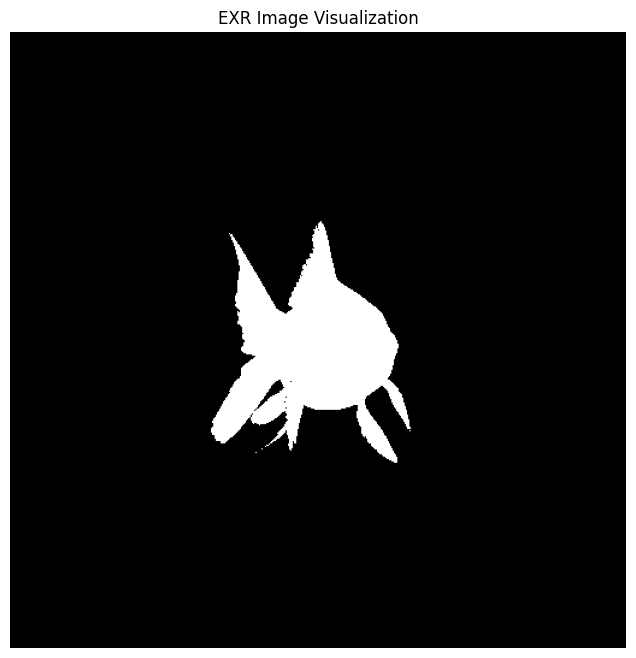

In [10]:
visualize_exr(exr_arr_re)